In [5]:
from embedding_model import EmbeddingModel
from typing import List
from transformers import AutoTokenizer, AutoModel, BertModel
import torch
from discourse import Discourse

In [1]:

from discourse import Discourse
from evaluate import load

In [12]:
sent = ["The sky is blue", "the weather is good", "the air is warm"]

In [3]:
metric = load("bertscore")


In [13]:
dis = Discourse(sent)
bertscore = dis.coherence_score(metric=metric)


In [14]:
bertscore

0.9103735983371735

In [34]:
bertscore2 = metric.compute(predictions=sent[1:], references=sent[:-1], lang="en")

In [38]:
type(bertscore2)

dict

In [27]:
sent = ["I live in Germany", "I study computer science"] 

In [60]:
encoded_input = bert_tokenizer(sent, padding=True, truncation=True, return_tensors='pt')
encoded_input

{'input_ids': tensor([[ 101, 1045, 2444, 1999, 2762,  102],
        [ 101, 1045, 2817, 3274, 2671,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]])}

In [66]:
bert_model(**encoded_input).keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])

In [67]:
from collections import defaultdict


In [75]:
idf_dict_hyp = defaultdict(lambda x: 0*x + 1.)

In [78]:
refs = ['The dog bit the man.', 'The dog had bit the man.']
sys = 'The dog bit the man.'

In [81]:
idf_dict_hyp = defaultdict(lambda: 1.)
idf_dict_ref = defaultdict(lambda: 1.)

### Reading JSON File

In [4]:
import pandas as pd
import json

In [5]:
file = open("../data/train_sessions.json", "r", encoding="utf8")
data = json.loads(file.read())

In [49]:
# normalized_data = pd.json_normalize(data, record_path=["turns", "passage"], 
#                                     meta=["session_id", ["turns", "qid"], ["turns", "query"], ["turns", "oracle_query"], ["turns", "answer"]])

In [6]:
normalized_data = pd.json_normalize(data, record_path=["turns"], 
                                    meta=["session_id"])

In [7]:
session_ids = normalized_data["session_id"].unique()

In [8]:
queries = normalized_data[normalized_data['session_id'] == session_ids[300]]['oracle_query'].tolist()

In [11]:
queries

['What is Venezuela?',
 'What is the capital and the largest city of colombia?',
 'What is the capital of peru?',
 'What is the capital of bolivia?',
 'What is the capital of chile?']

### Testing with Metrics

In [7]:
from evaluate import load 

In [8]:
from evaluate import load
bertscore = load("bertscore")
bleu = load("bleu")
rouge = load('rouge')

In [12]:
queries.append("blue sky in summer")

In [18]:
queries.pop(-1)

'blue sky in summer'

In [19]:
queries

['What is Venezuela?',
 'What is the capital and the largest city of colombia?',
 'What is the capital of peru?',
 'What is the capital of bolivia?',
 'What is the capital of chile?']

In [13]:
bertscore.compute(predictions=queries[1:], references=queries[:-1], lang="en", model_type="microsoft/deberta-xlarge-mnli")

{'precision': [0.5483058094978333,
  0.8842901587486267,
  0.9398562908172607,
  0.9501819610595703,
  0.5051981806755066],
 'recall': [0.6928839087486267,
  0.7621741890907288,
  0.9398562908172607,
  0.9501819610595703,
  0.5498039126396179],
 'f1': [0.612174391746521,
  0.8187035918235779,
  0.9398562908172607,
  0.9501819610595703,
  0.5265581011772156],
 'hashcode': 'microsoft/deberta-xlarge-mnli_L40_no-idf_version=0.3.12(hug_trans=4.36.2)'}

In [20]:
rouge.compute(predictions=queries[1:], references=queries[:-1])

{'rouge1': 0.6498397435897436,
 'rouge2': 0.5525974025974026,
 'rougeL': 0.6498397435897436,
 'rougeLsum': 0.6498397435897436}

In [21]:
bleu.compute(predictions=queries[1:], references=queries[:-1])

{'bleu': 0.3912711450183218,
 'precisions': [0.65625, 0.42857142857142855, 0.3333333333333333, 0.25],
 'brevity_penalty': 1.0,
 'length_ratio': 1.103448275862069,
 'translation_length': 32,
 'reference_length': 29}

## Testing with DiscoScore

In [22]:
from disco_score import DiscoScorer

Downloaded pre-trained UDPipe model for 'en' language


In [24]:
disco_scorer = DiscoScorer(model_name='bert-base-uncased')

AssertionError: Torch not compiled with CUDA enabled

## Testing with AnglE

In [10]:
from angle_emb import AnglE, Prompts

In [11]:
angle = AnglE.from_pretrained('WhereIsAI/UAE-Large-V1', pooling_strategy='cls').cuda()
angle.set_prompt(prompt=Prompts.C)

INFO:AnglE:Prompt is set, the prompt will be automatically applied during the encoding phase. To disable prompt setting, please configure set_prompt(prompt=None)


In [39]:
queries_dic = [{'text': query} for query in queries]
embeddings = angle.encode(queries_dic)


In [36]:
queries.append("the sky is blue")
queries

['What is Venezuela?',
 'What is the capital and the largest city of colombia?',
 'What is the capital of peru?',
 'What is the capital of bolivia?',
 'What is the capital of chile?',
 'the sky is blue',
 'the sky is blue']

## Trying with nouns only

In [23]:
from utils import *

In [33]:
sent1 = "I am a blue cloud person in germany"
sent2 = "the sky is blue"

In [30]:
similarity("cloud", "sky")

0.74419004

In [34]:
similarity(sent1, sent2)

0.7236823

In [25]:
similarity(get_nouns(sent1), get_nouns(sent2))

0.4209405

In [12]:
emb = angle.encode({"text": "Hello over there"})

In [ ]:
from moverscore_v2 import get_idf_dict, word_mover_score 
from collections import defaultdict

### New Test with BertScore

In [1]:
import bert_score
from bert_score import score
from bert_score import BERTScorer
scorer = BERTScorer(lang="en", rescale_with_baseline=False, model_type="microsoft/deberta-xlarge-mnli")
import numpy as np

In [2]:
import torch

In [3]:
def _compute_topic_coherence(session):

    session_size = len(session)
    similarities = torch.zeros(session_size, session_size)

    if session is not None:
        for i, query_i in enumerate(session):
            for j, query_j in enumerate(session):
                f1 = scorer.score([query_i], [query_j])[2].item()
                similarities[i, j] = f1


    return similarities


In [4]:
sessions = ['What is Venezuela?',
 'What is the capital and the largest city of colombia?',
 'What is the capital of peru?',
 'What is the capital of bolivia?',
 'What is the capital of chile?',
 'I want to eat chicken',
 'What is the language of south america?',
 'Is spanish popular in south america?'
]



In [6]:
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from session import Discourse

In [7]:
d = Discourse(sessions)

In [9]:
print('\n', d.topic_coherence_value, '\n', d.flow_coherence_value, '\n', d.flow_coherence_list)


 tensor(0.6200) 
 tensor(0.7493) 
 tensor([0.6122, 0.8187, 0.9399, 0.9502, 0.5892, 0.5766, 0.7585])


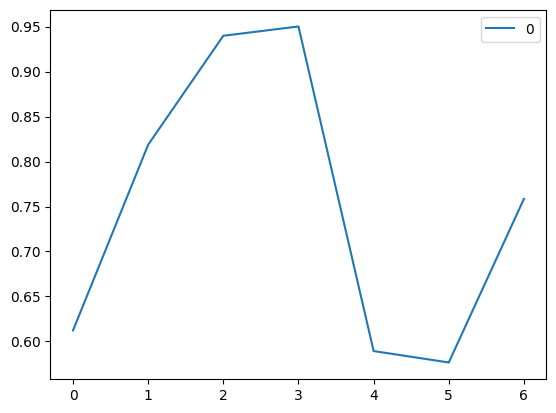

In [10]:
d.plot_flow_coherence()

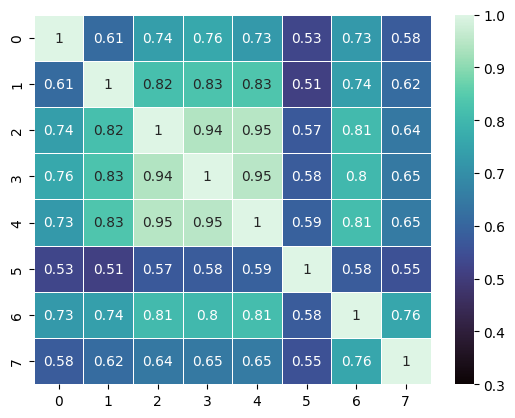

In [8]:
d.plot_topic_coherence()

In [6]:
d.add_entry("Hello my friend")

In [7]:
print('\n', d.topic_coherence_value, '\n', d.flow_coherence_value, '\n', d.flow_coherence_list)


 tensor(0.5924) 
 tensor(0.7143) 
 tensor([0.6122, 0.8187, 0.9399, 0.9502, 0.5892, 0.5766, 0.7585, 0.4690])


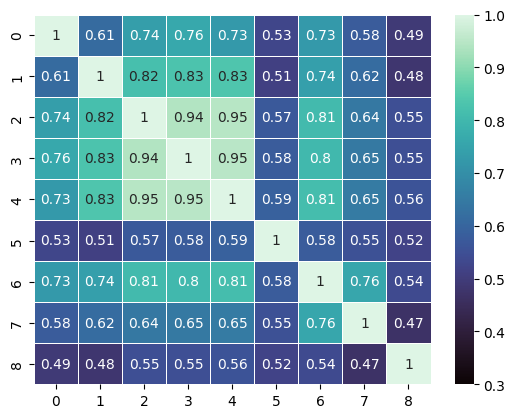

In [8]:
ax = sns.heatmap(d.topic_coherence_matrix, linewidth=0.5, cmap="mako", annot=True, vmin=0.3, vmax=1)
plt.show()

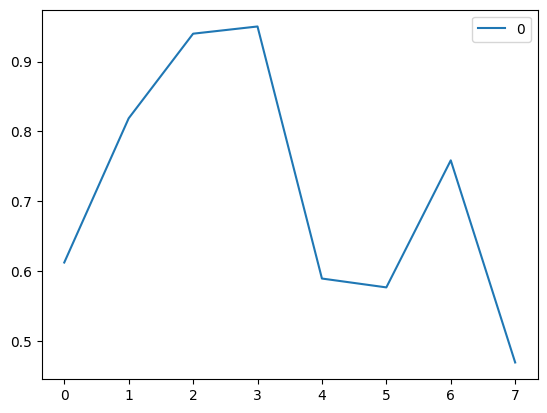

In [9]:

bx = sns.lineplot(data=pd.DataFrame(d.flow_coherence_list.numpy()))

plt.show()

In [47]:
import torch
t = torch.tensor([[1,2,3],
              [4,5,6]])
t

tensor([[1, 2, 3],
        [4, 5, 6]])

In [80]:
r = torch.zeros((1,3))
n = torch.cat((t, r), 0)
r = torch.zeros((3,1))
n = torch.cat((n, r), 1)
n[-2,-1] = 11
v = n[-2,-1]
torch.tensor([v.item()])

tensor([11.])

In [77]:
l = torch.tensor([1,2,3])
i = torch.tensor([4])

i

tensor([4])

In [14]:
import torch
new_column = torch.zeros((3, 1))
new_column[-1]=1
new_column

tensor([[0.],
        [0.],
        [1.]])

### Rouge Score


In [2]:
import evaluate

In [3]:
# Load the ROUGE evaluation metric
rouge = evaluate.load('rouge')

In [13]:
# Define the candidate predictions and reference sentences
predictions = ["hello there my friend from germany"]
references = ["hello there"]

# Compute the ROUGE score
results = rouge.compute(predictions=predictions, references=references)

# Print the results
print(results)

{'rouge1': 0.5, 'rouge2': 0.33333333333333337, 'rougeL': 0.5, 'rougeLsum': 0.5}


In [14]:
# Define the candidate predictions and reference sentences
predictions = ["hello my friend from germany there"]
references = ["hello there"]

# Compute the ROUGE score
results = rouge.compute(predictions=predictions, references=references)

# Print the results
print(results)

{'rouge1': 0.5, 'rouge2': 0.0, 'rougeL': 0.5, 'rougeLsum': 0.5}


In [20]:
# Define the candidate predictions and reference sentences
predictions = ["hello friend there"]
references = ["hello there"]

# Compute the ROUGE score
results = rouge.compute(predictions=predictions, references=references)

# Print the results
print(results)

{'rouge1': 0.8, 'rouge2': 0.0, 'rougeL': 0.8, 'rougeLsum': 0.8}


In [19]:
# Define the candidate predictions and reference sentences
predictions = ["hello my friend there"]
references = ["hello there"]

# Compute the ROUGE score
results = rouge.compute(predictions=predictions, references=references)

# Print the results
print(results)

{'rouge1': 0.6666666666666666, 'rouge2': 0.0, 'rougeL': 0.6666666666666666, 'rougeLsum': 0.6666666666666666}


In [21]:
bleu = evaluate.load("bleu")

In [32]:
# Define the candidate predictions and reference sentences
# predictions = ["hello there my friend"]
# references = ["hello there from germany my friend"]

references = ["hello there my friend"]
predictions = ["hello there from germany my friend"]

results = bleu.compute(predictions=predictions, references=references)
print(results)

{'bleu': 0.0, 'precisions': [0.6666666666666666, 0.4, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 1.5, 'translation_length': 6, 'reference_length': 4}


### Test Using Rescale

In [16]:
from bert_score import score, plot_example

In [82]:
session = ['What Venezuela?',
 'What capital largest city colombia?',
 'What capital peru?',
 'What is the capital of bolivia?',
 'What is the capital of chile?',
 'I want to eat chicken',
 'What is the language of south america?',
 'Is spanish popular in south america?'
]

refs = session[:-1]

refs = ["What is the biggest country in the world?"]

cands = session[1:]

cands = ["is russia the biggest country?"]

In [ ]:
stop_words = ["is", "of", "the", "and", "to", "in"] 

def pre_process(session):
    for sent in session:
        for word in sent.split():
            if word in stop_words:
                sent = sent.replace(word, ' ')

print(session[1], pre_process([session[1]]))
    

In [50]:
stop_words = ["is", "of", "the", "and", "to", "in"] 

x = [session[1]]
for sent in x:


print(x)

['What is the capital and the largest city of colombia?']


c:\Users\a.almasri\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\t5\tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


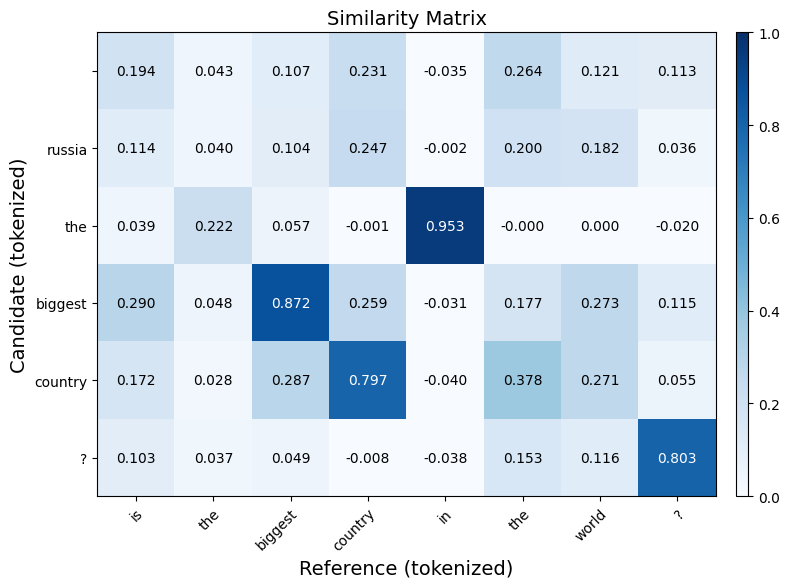

In [83]:
plot_example(lang="en", candidate=cands[0], reference=refs[0] ,rescale_with_baseline=False, model_type="t5-large")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


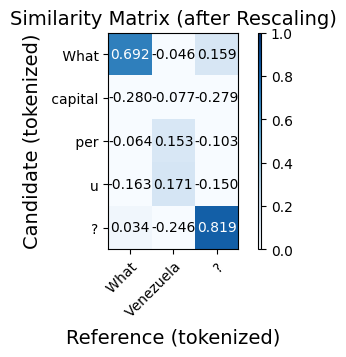

In [63]:
plot_example(lang="en", candidate=cands[1], reference=refs[0] ,rescale_with_baseline=True)

In [ ]:
out = score(
    cands, refs, 
    rescale_with_baseline=True, lang="en"
)

In [15]:
out.bert-score-show()

AttributeError: 'tuple' object has no attribute 'bert'